# Import Packages

In [1]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19

from tensorflow.keras.applications.resnet50 import ResNet50

In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Activation, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.metrics import Recall, Precision

import os
import glob
from pathlib import Path

In [224]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix, plot_confusion_matrix

In [280]:
from sklearn.decomposition import PCA

In [3]:
%matplotlib inline

# Introduction

Clinical Dementia Ratings (CDR) are provided in the dataset with the following attributions:

    0 = no dementia, 0.5 = very mild AD, 1 = mild AD, 2 = moderate AD

For the purpose of analysis, all patients with a CDR of 0 are giving a diagnosis of 0, denoting cognitively healthy. CDR ratings above 0 are converted to 1, for an AD diagnosis, and binary classification.

diagnosis_qual={0.:'normal', 0.5:'AD', 1.:'AD', 2.:'AD' }


# Load OASIS1 Diagnosis

In [4]:
user_path = Path('/Users/mkv/code/mkvph0ch/memobrain/')
gcp_path = 'gs://memobrain/raw_data/'

oas1_dia_file = user_path.joinpath('raw_data/OASIS1/oasis_cross-sectional.csv')

In [5]:
# load to pandas df, show head
oas1_dia_df = pd.read_csv(oas1_dia_file )
oas1_dia_df.head()

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN


In [6]:
# make copy and extract only relevant columns
oas1_dia = oas1_dia_df.copy()[['ID', 'CDR']]
oas1_dia

,ID,CDR
0,OAS1_0001_MR1,0.0
1,OAS1_0002_MR1,0.0
2,OAS1_0003_MR1,0.5
3,OAS1_0004_MR1,NaN
4,OAS1_0005_MR1,NaN
...,...,...
431,OAS1_0285_MR2,NaN
432,OAS1_0353_MR2,NaN
433,OAS1_0368_MR2,NaN
434,OAS1_0379_MR2,NaN


In [7]:
# drop all missing values
oas1_dia.dropna(inplace=True)

In [8]:
# check the shape
oas1_dia.shape

(235, 2)

In [9]:
# check the values
oas1_dia['CDR'].value_counts()

0.0    135
0.5     70
1.0     28
2.0      2
Name: CDR, dtype: int64

In [10]:
def binary_target(value):
    '''convert all dementia to 1, leave no dementia to 0'''
    if value != 0:
        return 1
    else:
        return value

In [11]:
oas1_dia['CDR'] = oas1_dia['CDR'].apply(lambda x: binary_target(x))

In [12]:
oas1_dia['CDR'].value_counts()

0.0    135
1.0    100
Name: CDR, dtype: int64

In [19]:
dummy_noAD = 135/(135+100)
dummy_AD = 100/(135+100)
print(dummy_noAD, dummy_AD)

0.574468085106383 0.425531914893617


In [21]:
assert((dummy_noAD**2) + 2*(dummy_noAD*dummy_AD) + (dummy_AD**2) == 1)

In [16]:
# check if binary_target function worked correct
assert(oas1_dia['CDR'].value_counts().values[1] == oas1_dia['CDR'].value_counts().values[1:].sum())

# Load OASIS1 MRI Images

In [22]:
# find all Data, e.g. in OASIS 1
local_path_oas1 = user_path.joinpath('raw_data/OASIS1/OAS1_RAW/')
local_path_oas1

PosixPath('/Users/mkv/code/mkvph0ch/memobrain/raw_data/OASIS1/OAS1_RAW')

In [23]:
def find_files_specific(file_ext, list_dirs, cpath):
    '''find all processed images with {file_ext} in {cpath} which are in list_dirs
    file_ext: str
    cpath: str
    '''
    # join all path
    all_paths = []
    for item in list(oas1_dia['ID']):
        all_paths.append(local_path_oas1.joinpath(item).joinpath('PROCESSED/MPRAGE/T88_111/'))
    
    all_jpgs = []
    
    for file_path in all_paths:
        for jpg_path in file_path.glob(f"*_t88_gfc_*.{file_ext}"):
            all_jpgs.append(jpg_path)

    return all_jpgs

In [25]:
# load specific jpgs in OASIS1
oasis1_sp_jpg_paths = find_files_specific('jpg', list_dirs=list(oas1_dia['ID']), cpath=str(local_path_oas1))
len(oasis1_sp_jpg_paths)

705

In [26]:
oasis1_sp_jpg_paths[0:3]

[PosixPath('/Users/mkv/code/mkvph0ch/memobrain/raw_data/OASIS1/OAS1_RAW/OAS1_0001_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0001_MR1_mpr_n4_anon_111_t88_gfc_sag_95.jpg'),
 PosixPath('/Users/mkv/code/mkvph0ch/memobrain/raw_data/OASIS1/OAS1_RAW/OAS1_0001_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0001_MR1_mpr_n4_anon_111_t88_gfc_cor_110.jpg'),
 PosixPath('/Users/mkv/code/mkvph0ch/memobrain/raw_data/OASIS1/OAS1_RAW/OAS1_0001_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0001_MR1_mpr_n4_anon_111_t88_gfc_tra_90.jpg')]

# Plot OASIS1 Images

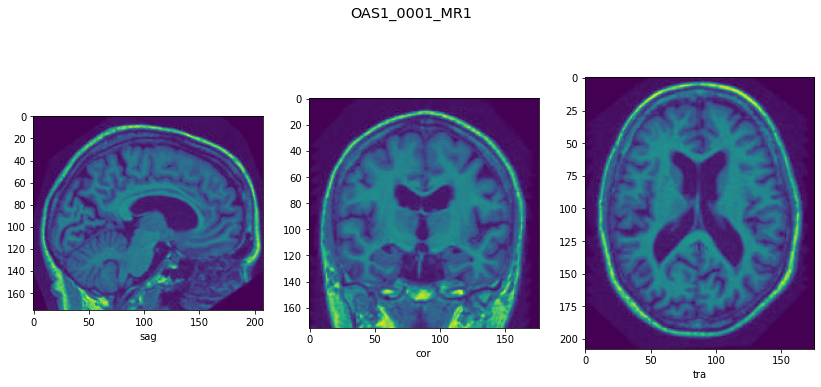

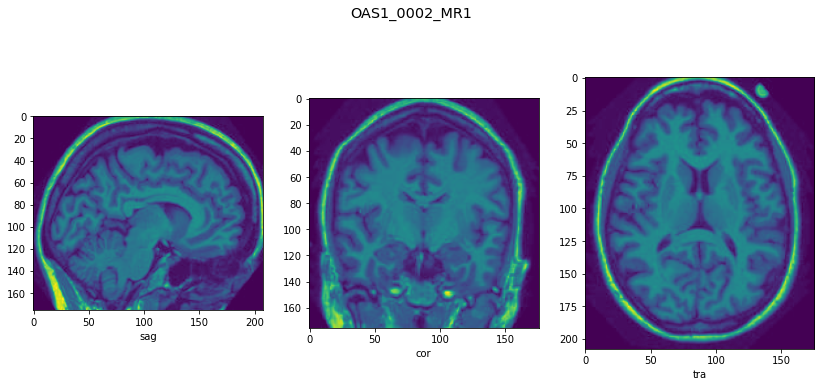

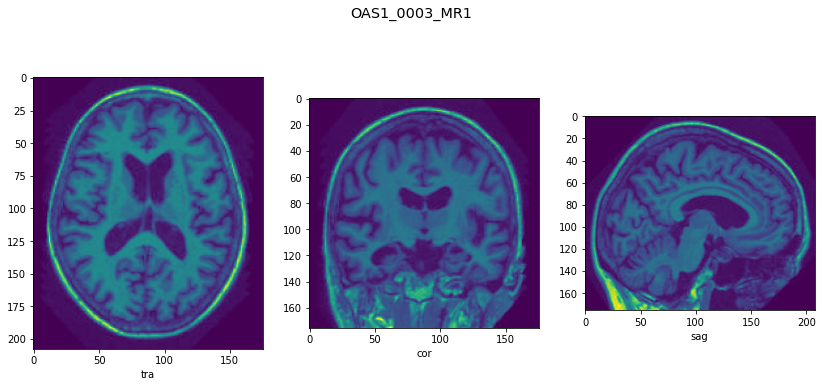

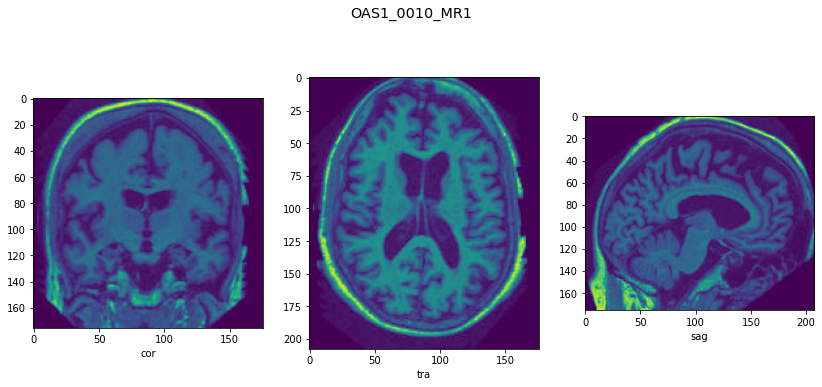

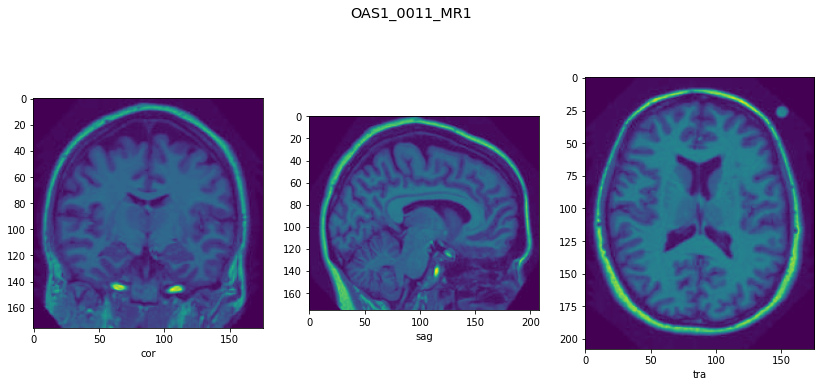

In [28]:
for i in range(0, 15, 3):
    img_01 = plt.imread(oasis1_sp_jpg_paths[i])
    img_02 = plt.imread(oasis1_sp_jpg_paths[i+1])
    img_03 = plt.imread(oasis1_sp_jpg_paths[i+2])

    fig, axs = plt.subplots(1,3, figsize=(14, 6))
    fig.suptitle(str(oasis1_sp_jpg_paths[i].parent).split('/')[-4], fontsize='x-large')
    
    axs[0].imshow(img_01)
    axs[0].set_xlabel(oasis1_sp_jpg_paths[i].stem.split('_')[-2])
    
    axs[1].imshow(img_02)
    axs[1].set_xlabel(oasis1_sp_jpg_paths[i+1].stem.split('_')[-2])
    
    axs[2].imshow(img_03)
    axs[2].set_xlabel(oasis1_sp_jpg_paths[i+2].stem.split('_')[-2])

# Preprocess OASIS1 MRI Images

In [29]:
oasis1_dict = {
    'Folder': [],
    'Dataset': [],
    'Subject_ID': [],
    'MR': [],
    'n': [],
    'orient': [],
    'image_arr': [],
    'CDR': []
}

In [30]:
# iterate over all jpg paths and append to dictionary

for i in range(0, len(oasis1_sp_jpg_paths)):
    # data from csv
    oasis1_dict['Folder'].append(oasis1_sp_jpg_paths[i].stem.split('_mpr')[0])
    oasis1_dict['Dataset'].append(oasis1_sp_jpg_paths[i].stem.split('_')[0])
    oasis1_dict['Subject_ID'].append(oasis1_sp_jpg_paths[i].stem.split('_')[1])
    oasis1_dict['MR'].append(oasis1_sp_jpg_paths[i].stem.split('_')[2][-1])
    oasis1_dict['n'].append(oasis1_sp_jpg_paths[i].stem.split('_')[4][-1])
    oasis1_dict['orient'].append(oasis1_sp_jpg_paths[i].stem.split('_')[-2])
    
    # images
    img = plt.imread(oasis1_sp_jpg_paths[i])
    img = img.reshape(img.shape[0], img.shape[1], 1) # array -> tensor
    oasis1_dict['image_arr'].append(img)

In [31]:
for item in oasis1_dict['Folder']:
    cdr = int(oas1_dia[oas1_dia['ID'] == item]['CDR'].values[0])
    oasis1_dict['CDR'].append(cdr)

In [32]:
oasis1_df = pd.DataFrame.from_dict(oasis1_dict)
oasis1_df.head(20)

,Folder,Dataset,Subject_ID,MR,n,orient,image_arr,CDR
0,OAS1_0001_MR1,OAS1,0001,1,4,sag,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",0
1,OAS1_0001_MR1,OAS1,0001,1,4,cor,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",0
2,OAS1_0001_MR1,OAS1,0001,1,4,tra,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",0
3,OAS1_0002_MR1,OAS1,0002,1,4,sag,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",0
4,OAS1_0002_MR1,OAS1,0002,1,4,cor,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",0
5,OAS1_0002_MR1,OAS1,0002,1,4,tra,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",0
6,OAS1_0003_MR1,OAS1,0003,1,4,tra,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",1
7,OAS1_0003_MR1,OAS1,0003,1,4,cor,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",1
8,OAS1_0003_MR1,OAS1,0003,1,4,sag,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",1
9,OAS1_0010_MR1,OAS1,0010,1,4,cor,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",0


In [34]:
oasis1_sag = oasis1_df[oasis1_df['orient'] == 'sag'].reset_index(drop=True)

In [35]:
oasis1_tra = oasis1_df[oasis1_df['orient'] == 'tra'].reset_index(drop=True)

In [36]:
oasis1_cor = oasis1_df[oasis1_df['orient'] == 'cor'].reset_index(drop=True)

In [ ]:
oasis1_df.to_pickle(user_path.joinpath('raw_data/OASIS1/oasis1_df.pkl'))
oasis1_sag.to_pickle(user_path.joinpath('raw_data/OASIS1/oasis1_sag.pkl'))
oasis1_tra.to_csv(user_path.joinpath('raw_data/OASIS1/oasis1_tra.pkl'))
oasis1_cor.to_csv(user_path.joinpath('raw_data/OASIS1/oasis1_cor.pkl'))

# OASIS1 Train Test split

In [37]:
def convert2tensor(array):
    return np.array([image for image in array])

In [38]:
X_oas1_cor = convert2tensor(oasis1_cor['image_arr'].values)
y_oas1_cor = oasis1_cor['CDR'].values

In [40]:
X_train_oas1_cor, X_test_oas1_cor, y_train_oas1_cor, y_test_oas1_cor =\
train_test_split(X_oas1_cor, y_oas1_cor, test_size=.3, random_state=42)

In [41]:
X_oas1_sag = convert2tensor(oasis1_sag['image_arr'].values)
y_oas1_sag = oasis1_sag['CDR'].values

In [57]:
X_train_oas1_sag, X_test_oas1_sag, y_train_oas1_sag, y_test_oas1_sag =\
train_test_split(X_oas1_sag, y_oas1_sag, test_size=.3, random_state=42)

In [45]:
X_oas1_tra = convert2tensor(oasis1_tra['image_arr'].values)
y_oas1_tra = oasis1_tra['CDR'].values

In [46]:
X_train_oas1_tra, X_test_oas1_tra, y_train_oas1_tra, y_test_oas1_tra =\
train_test_split(X_oas1_tra, y_oas1_tra, test_size=.3, random_state=42)

# Convolutional neural network

In [50]:
input_shape_oas1_cor = (176, 176, 1)
input_shape_oas1_sag = (176, 208, 1)
input_shape_oas1_tra = (208, 176, 1)

def create_model(input_sh):
    model = Sequential()
    model.add(Conv2D(100, kernel_size=(3, 3), strides=(10,10),
                     activation='sigmoid', padding ='same',
                     input_shape=input_sh))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
    model.add(Conv2D(50, (3, 3), activation='sigmoid', strides=(5,5), padding ='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
    model.add(Conv2D(25, kernel_size=(3,3), activation='sigmoid', strides = (1,1), padding ='same'))
    model.add(MaxPooling2D(pool_size=(1, 1), padding='valid'))
    model.add(Flatten())
    #model.add(Dense(16, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', 'Recall', 'Precision'])
    
    return model

In [ ]:
plot_loss_accuracy

In [216]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- ACCURACY
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    if title:
        fig.suptitle(title)

# OASIS1

In [51]:
basic_cnn_oas1_cor = create_model(input_shape_oas1_cor)

basic_cnn_oas1_sag = create_model(input_shape_oas1_sag)

basic_cnn_oas1_tra = create_model(input_shape_oas1_tra)

In [52]:
es = EarlyStopping(monitor='loss', patience=10)

In [53]:
history__oas1_cor = basic_cnn_oas1_cor.fit(X_train_oas1_cor, y_train_oas1_cor, 
                                epochs=500,
                                verbose=0,
                                batch_size=32,
                                callbacks=[es])

In [54]:
basic_cnn_oas1_cor.evaluate(X_test_oas1_cor, y_test_oas1_cor)

3/3 [==============================] - 0s 3ms/step - loss: 1.2179 - accuracy: 0.6479 - recall: 0.5862 - precision: 0.5667


[1.2179375886917114,
 0.6478873491287231,
 0.5862069129943848,
 0.5666666626930237]

In [263]:
def plot_cf_matrix(cf_matrix, model_name):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    
    labels = [f"{v1}\n\n{v2}" for v1, v2 in zip(group_names,group_counts)]
    
    labels = np.asarray(labels).reshape(2,2)
    
    plt.title(model_name)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    
    return None

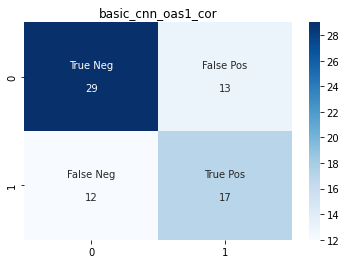

In [264]:
y_pred_oas1_cor = np.round(basic_cnn_oas1_cor.predict(X_test_oas1_cor), 0)

conf_matrix_oas1_cor = confusion_matrix(y_true=y_test_oas1_cor, y_pred=y_pred_oas1_cor)

plot_cf_matrix(conf_matrix_oas1_cor, 'basic_cnn_oas1_cor')

In [55]:
history_oas1_sag = basic_cnn_oas1_sag.fit(X_train_oas1_sag, y_train_oas1_sag, 
                                epochs=500,
                                verbose=0,
                                batch_size=32,
                                callbacks=[es])

In [58]:
basic_cnn_oas1_sag.evaluate(X_test_oas1_sag, y_test_oas1_sag)

3/3 [==============================] - 0s 3ms/step - loss: 1.4962 - accuracy: 0.6479 - recall: 0.5517 - precision: 0.5714


[1.4961962699890137,
 0.6478873491287231,
 0.5517241358757019,
 0.5714285969734192]

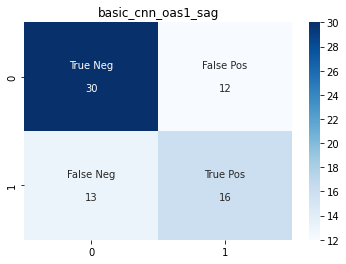

In [265]:
y_pred_oas1_sag = np.round(basic_cnn_oas1_sag.predict(X_test_oas1_sag), 0)

conf_matrix_oas1_sag = confusion_matrix(y_true=y_test_oas1_sag, y_pred=y_pred_oas1_sag)

plot_cf_matrix(conf_matrix_oas1_sag, 'basic_cnn_oas1_sag')

In [59]:
history_oas1_tra = basic_cnn_oas1_tra.fit(X_train_oas1_tra, y_train_oas1_tra, 
                                epochs=500,
                                verbose=0,
                                batch_size=32,
                                callbacks=[es])

In [60]:
basic_cnn_oas1_tra.evaluate(X_test_oas1_tra, y_test_oas1_tra)

3/3 [==============================] - 0s 3ms/step - loss: 1.3839 - accuracy: 0.7042 - recall: 0.6207 - precision: 0.6429


[1.3839092254638672,
 0.7042253613471985,
 0.6206896305084229,
 0.6428571343421936]

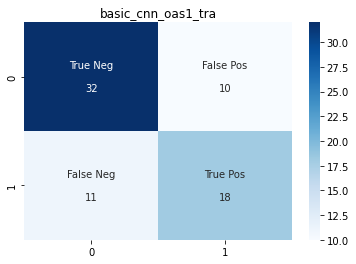

In [266]:
y_pred_oas1_tra = np.round(basic_cnn_oas1_tra.predict(X_test_oas1_tra), 0)

conf_matrix_oas1_tra = confusion_matrix(y_true=y_test_oas1_tra, y_pred=y_pred_oas1_tra)

plot_cf_matrix(conf_matrix_oas1_tra, 'basic_cnn_oas1_tra')

## OASIS1 Concatinated Non Raw Images

In [89]:
# load OASIS1 concat pickle file
oas1_concat_df_file = user_path.joinpath('raw_data/OASIS1/oasis1_concat.pkl') #from GH
oas1_concat_df = pd.read_pickle(oas1_concat_df_file)
oas1_concat_df.head()

,Subject_ID,concat_img,CDR
0,0001,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",0
1,0002,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",0
2,0003,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",1
3,0010,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",0
4,0011,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",0


In [90]:
X_oas1_concat = np.array([x for x in oas1_concat_df.concat_img])
y_oas1_concat = oas1_concat_df['CDR'].values

In [91]:
X_train_oas1_concat, X_test_oas1_concat, y_train_oas1_concat, y_test_oas1_concat =\
train_test_split(X_oas1_concat, y_oas1_concat, test_size=0.3, random_state=42)

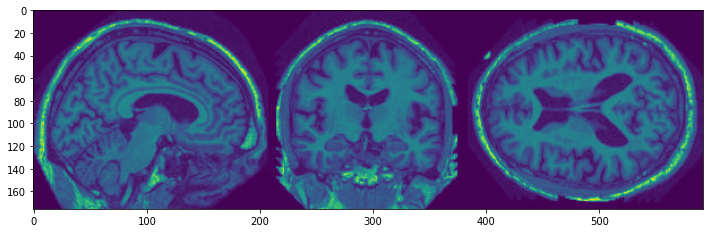

In [92]:
plt.figure(figsize=(12,5))
plt.imshow(X_train_oas1_concat[0])

In [93]:
base_cnn_oas1_concat = create_model(X_train_oas1_concat[0].shape)

In [94]:
es = EarlyStopping(monitor='loss', patience=10)

history_oas1_concat = base_cnn_oas1_concat.fit(X_train_oas1_concat, y_train_oas1_concat, 
                                epochs=500,
                                verbose=0,
                                batch_size=32,
                                callbacks=[es])

In [95]:
base_cnn_oas1_concat.evaluate(X_test_oas1_concat, y_test_oas1_concat)

3/3 [==============================] - 0s 4ms/step - loss: 1.3015 - accuracy: 0.6901 - recall: 0.4828 - precision: 0.6667


[1.3014771938323975,
 0.6901408433914185,
 0.48275861144065857,
 0.6666666865348816]

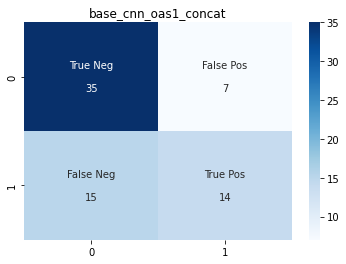

In [267]:
y_pred_oas1_concat = np.round(base_cnn_oas1_concat.predict(X_test_oas1_concat), 0)

conf_matrix_oas1_concat = confusion_matrix(y_true=y_test_oas1_concat, y_pred=y_pred_oas1_concat)

plot_cf_matrix(conf_matrix_oas1_concat, 'base_cnn_oas1_concat')

# OASIS 2

In [61]:
# load OASIS2 pickle file
oas2_df_file = user_path.joinpath('raw_data/OASIS2/oas2_df.pkl') #from GH
oas2_df = pd.read_pickle(oas2_df_file)
oas2_df.head()

,full_path,image,plane,subject_id,session,file_names,CDR
0,../raw_data/OASIS2/OAS2_RAW/OAS2_0001_MR1/RAW/...,"[[[59.92892578718232], [199.1923654299807], [1...",sag,OAS2_0001,MR1,mpr-1.nifti.img,0
1,../raw_data/OASIS2/OAS2_RAW/OAS2_0001_MR1/RAW/...,"[[[71.67888621794873], [256.4102712060012], [1...",tra,OAS2_0001,MR1,mpr-1.nifti.img,0
2,../raw_data/OASIS2/OAS2_RAW/OAS2_0001_MR1/RAW/...,"[[[73.87677356656945], [162.90141406094403], [...",cor,OAS2_0001,MR1,mpr-1.nifti.img,0
3,../raw_data/OASIS2/OAS2_RAW/OAS2_0001_MR1/RAW/...,"[[[63.69345293138525], [134.62243886318572], [...",sag,OAS2_0001,MR1,mpr-2.nifti.img,0
4,../raw_data/OASIS2/OAS2_RAW/OAS2_0001_MR1/RAW/...,"[[[77.22216097023147], [77.22216097023147], [1...",tra,OAS2_0001,MR1,mpr-2.nifti.img,0


In [62]:
# seperate by plane
oas2_sag = oas2_df[oas2_df['plane'] == 'sag']
oas2_cor = oas2_df[oas2_df['plane'] == 'cor']
oas2_tra = oas2_df[oas2_df['plane'] == 'tra']

In [63]:
# saggital
X_oas2_sag = np.array([x for x in oas2_sag.image])
y_oas2_sag = oas2_sag['CDR'].values

X_train_oas2_sag, X_test_oas2_sag, y_train_oas2_sag, y_test_oas2_sag =\
        train_test_split(X_oas2_sag, y_oas2_sag, test_size=.3, random_state=42)

# tra
X_oas2_tra = np.array([x for x in oas2_cor.image])
y_oas2_tra = oas2_tra['CDR'].values

X_train_oas2_tra, X_test_oas2_tra, y_train_oas2_tra, y_test_oas2_tra =\
        train_test_split(X_oas2_tra, y_oas2_tra, test_size=.3, random_state=42)

# cor
X_oas2_cor = np.array([x for x in oas2_tra.image])
y_oas2_cor = oas2_cor['CDR'].values

X_train_oas2_cor, X_test_oas2_cor, y_train_oas2_cor, y_test_oas2_cor =\
        train_test_split(X_oas2_cor, y_oas2_cor, test_size=.3, random_state=42)

In [64]:
X_train_oas2_sag[0].shape

(256, 256, 1)

In [65]:
X_train_oas2_tra[0].shape

(256, 128, 1)

In [66]:
X_train_oas2_cor[0].shape

(256, 128, 1)

In [68]:
basic_cnn_oas2_cor = create_model(X_train_oas2_cor[0].shape)

basic_cnn_oas2_sag = create_model(X_train_oas2_sag[0].shape)

basic_cnn_oas2_tra = create_model(X_train_oas2_tra[0].shape)

In [69]:
history_oas2_cor = basic_cnn_oas2_cor.fit(X_train_oas2_cor, y_train_oas2_cor, 
                                epochs=500,
                                verbose=0,
                                batch_size=32,
                                callbacks=[es])

In [70]:
basic_cnn_oas2_cor.evaluate(X_test_oas2_cor, y_test_oas2_cor)

13/13 [==============================] - 0s 2ms/step - loss: 0.7231 - accuracy: 0.5985 - recall: 0.0852 - precision: 0.7895


[0.7231348156929016,
 0.5985401272773743,
 0.08522727340459824,
 0.7894737124443054]

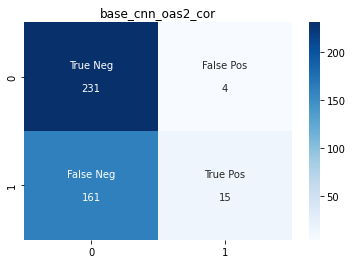

In [270]:
y_pred_oas2_cor = np.round(basic_cnn_oas2_cor.predict(X_test_oas2_cor), 0)

conf_matrix_oas2_cor = confusion_matrix(y_true=y_test_oas2_cor, y_pred=y_pred_oas2_cor)

plot_cf_matrix(conf_matrix_oas2_cor, 'base_cnn_oas2_cor')

In [71]:
history_sag = basic_cnn_oas2_sag.fit(X_train_oas2_sag, y_train_oas2_sag, 
                                epochs=500,
                                verbose=0,
                                batch_size=32,
                                callbacks=[es])

In [72]:
basic_cnn_oas2_sag.evaluate(X_test_oas2_sag, y_test_oas2_sag)

13/13 [==============================] - 0s 3ms/step - loss: 0.6728 - accuracy: 0.5718 - recall: 0.2386 - precision: 0.5000


[0.6728111505508423, 0.5717761516571045, 0.23863635957241058, 0.5]

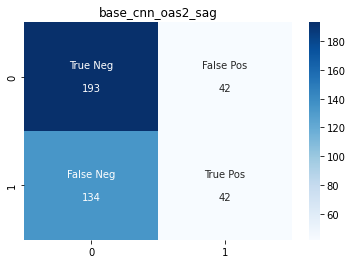

In [271]:
y_pred_oas2_sag = np.round(basic_cnn_oas2_sag.predict(X_test_oas2_sag), 0)

conf_matrix_oas2_sag = confusion_matrix(y_true=y_test_oas2_sag, y_pred=y_pred_oas2_sag)

plot_cf_matrix(conf_matrix_oas2_sag, 'base_cnn_oas2_sag')

In [73]:
history_sag = basic_cnn_oas2_tra.fit(X_train_oas2_tra, y_train_oas2_tra, 
                                epochs=500,
                                verbose=0,
                                batch_size=32,
                                callbacks=[es])

In [74]:
basic_cnn_oas2_tra.evaluate(X_test_oas2_tra, y_test_oas2_tra)

13/13 [==============================] - 0s 2ms/step - loss: 0.6853 - accuracy: 0.5718 - recall: 0.0000e+00 - precision: 0.0000e+00


[0.6852505803108215, 0.5717761516571045, 0.0, 0.0]

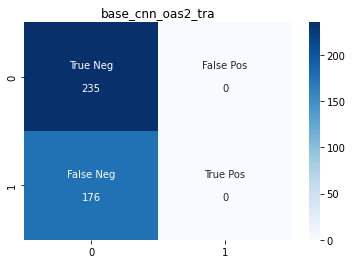

In [269]:
y_pred_oas2_tra = np.round(basic_cnn_oas2_tra.predict(X_test_oas2_tra), 0)

conf_matrix_oas2_tra = confusion_matrix(y_true=y_test_oas2_tra, y_pred=y_pred_oas2_tra)

plot_cf_matrix(conf_matrix_oas2_tra, 'base_cnn_oas2_tra')

## OASIS 2 Concatinated Images

In [75]:
# import OASIS2 concated
oas2_concat_file = user_path.joinpath('raw_data/OASIS2/oas2_concat.pkl')
oas2_concat = pd.read_pickle(oas2_concat_file)
oas2_concat.head()

,full_path,subject_id,session,file_names,CDR,concated
0,../raw_data/OASIS2/OAS2_RAW/OAS2_0001_MR1/RAW/...,OAS2_0001,MR1,mpr-1.nifti.img,0,"[[[59.92892578718232], [199.1923654299807], [1..."
1,../raw_data/OASIS2/OAS2_RAW/OAS2_0001_MR1/RAW/...,OAS2_0001,MR1,mpr-2.nifti.img,0,"[[[63.69345293138525], [134.62243886318572], [..."
2,../raw_data/OASIS2/OAS2_RAW/OAS2_0001_MR1/RAW/...,OAS2_0001,MR1,mpr-3.nifti.img,0,"[[[200.25682718365644], [59.54695643622773], [..."
3,../raw_data/OASIS2/OAS2_RAW/OAS2_0001_MR2/RAW/...,OAS2_0001,MR2,mpr-1.nifti.img,0,"[[[140.0265449319469], [66.37793075925373], [6..."
4,../raw_data/OASIS2/OAS2_RAW/OAS2_0001_MR2/RAW/...,OAS2_0001,MR2,mpr-2.nifti.img,0,"[[[199.62401708571983], [60.976264764876305], ..."


In [77]:
X_oas2_concat = np.array([x for x in oas2_concat.concated]) #np.array(oas2_concat['concated'].values)
y_oas2_concat = oas2_concat['CDR'].values

In [83]:
X_train_oas2_concat, X_test_oas2_concat, y_train_oas2_concat, y_test_oas2_concat =\
train_test_split(X_oas2_concat, y_oas2_concat, test_size=0.3, random_state=42)

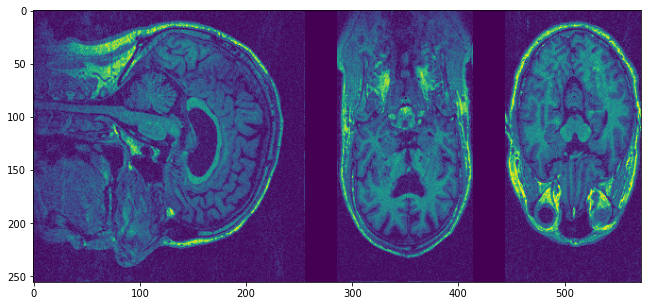

In [87]:
plt.figure(figsize=(12,5))
plt.imshow(X_train_oas2_concat[0])

In [84]:
X_train_oas2_concat[0].shape

(256, 572, 1)

In [85]:
base_cnn_oas2_concat = create_model(X_train_oas2_concat[0].shape)

In [86]:
es = EarlyStopping(monitor='loss', patience=10)

history_oas2_concat = base_cnn_oas2_concat.fit(X_train_oas2_concat, y_train_oas2_concat, 
                                epochs=500,
                                verbose=0,
                                batch_size=32,
                                callbacks=[es])

In [88]:
base_cnn_oas2_concat.evaluate(X_test_oas2_concat, y_test_oas2_concat)

13/13 [==============================] - 0s 6ms/step - loss: 2.3423 - accuracy: 0.6399 - recall: 0.5795 - precision: 0.5795


[2.3422648906707764, 0.639902651309967, 0.5795454382896423, 0.5795454382896423]

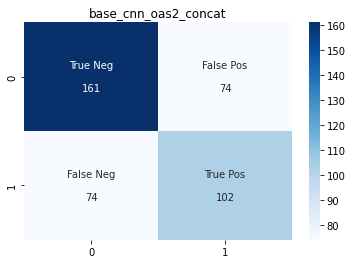

In [273]:
y_pred_oas2_concat = np.round(base_cnn_oas2_concat.predict(X_test_oas2_concat), 0)

conf_matrix_oas2_concat = confusion_matrix(y_true=y_test_oas2_concat, y_pred=y_pred_oas2_concat)

plot_cf_matrix(conf_matrix_oas2_concat, 'base_cnn_oas2_concat')

# OASIS1 masked gifs

In [96]:
def find_files_specific(file_ext, list_dirs, cpath):
    '''find all processed images with {file_ext} in {cpath} which are in list_dirs
    file_ext: str
    cpath: str
    '''
    # join all path
    all_paths = []
    for item in list(oas1_dia['ID']):
        all_paths.append(local_path_oas1.joinpath(item).joinpath('PROCESSED/MPRAGE/T88_111/'))
    
    all_jpgs = []
    
    for file_path in all_paths:
        for jpg_path in file_path.glob(f"*_t88_masked_*.{file_ext}"):
            all_jpgs.append(jpg_path)

    return all_jpgs

In [104]:
# load specific jpgs in OASIS1
oasis1_masked_gifs_paths = find_files_specific('gif', list_dirs=list(oas1_dia['ID']), cpath=str(local_path_oas1))
len(oasis1_masked_gifs_paths)

235

In [105]:
oasis1_masked_gifs_paths[0]

PosixPath('/Users/mkv/code/mkvph0ch/memobrain/raw_data/OASIS1/OAS1_RAW/OAS1_0001_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0001_MR1_mpr_n4_anon_111_t88_masked_gfc_tra_90.gif')

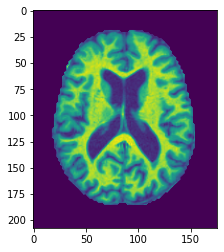

In [99]:
plt.imshow(plt.imread(oasis1_masked_gifs_paths[0]))

In [125]:
oas1_masked_gifs_dict = {
    "Folder": [],
    "Subject_ID": [],
    "MR": [],
    "img": [],
    "CDR": []
}

In [126]:
# iterate over all jpg paths and append to dictionary

for i in range(0, len(oasis1_masked_gifs_paths)):
    # data from csv
    oas1_masked_gifs_dict['Folder'].append(oasis1_masked_gifs_paths[i].name.split('_mpr')[0])
    oas1_masked_gifs_dict['Subject_ID'].append(oasis1_masked_gifs_paths[i].name.split('_MR')[0])
    oas1_masked_gifs_dict['MR'].append(oasis1_masked_gifs_paths[i].name.split('_')[2][-1])
    
    # images
    img = plt.imread(oasis1_masked_gifs_paths[i])
    img = img.reshape(img.shape[0], img.shape[1], 1) # array -> tensor
    oas1_masked_gifs_dict['img'].append(img)

In [137]:
for item in oas1_masked_gifs_dict['Folder']:
    cdr = int(oas1_dia[oas1_dia['ID'] == item]['CDR'].values[0])
    oas1_masked_gifs_dict['CDR'].append(cdr)

In [140]:
oas1_masked_gifs_df = pd.DataFrame.from_dict(oas1_masked_gifs_dict)
oas1_masked_gifs_df.head(20)

,Folder,Subject_ID,MR,img,CDR
0,OAS1_0001_MR1,OAS1_0001,1,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",0
1,OAS1_0002_MR1,OAS1_0002,1,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",0
2,OAS1_0003_MR1,OAS1_0003,1,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",1
3,OAS1_0010_MR1,OAS1_0010,1,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",0
4,OAS1_0011_MR1,OAS1_0011,1,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",0
5,OAS1_0013_MR1,OAS1_0013,1,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",0
6,OAS1_0015_MR1,OAS1_0015,1,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",1
7,OAS1_0016_MR1,OAS1_0016,1,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",1
8,OAS1_0018_MR1,OAS1_0018,1,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",0
9,OAS1_0019_MR1,OAS1_0019,1,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",0


## Plot masked gifs

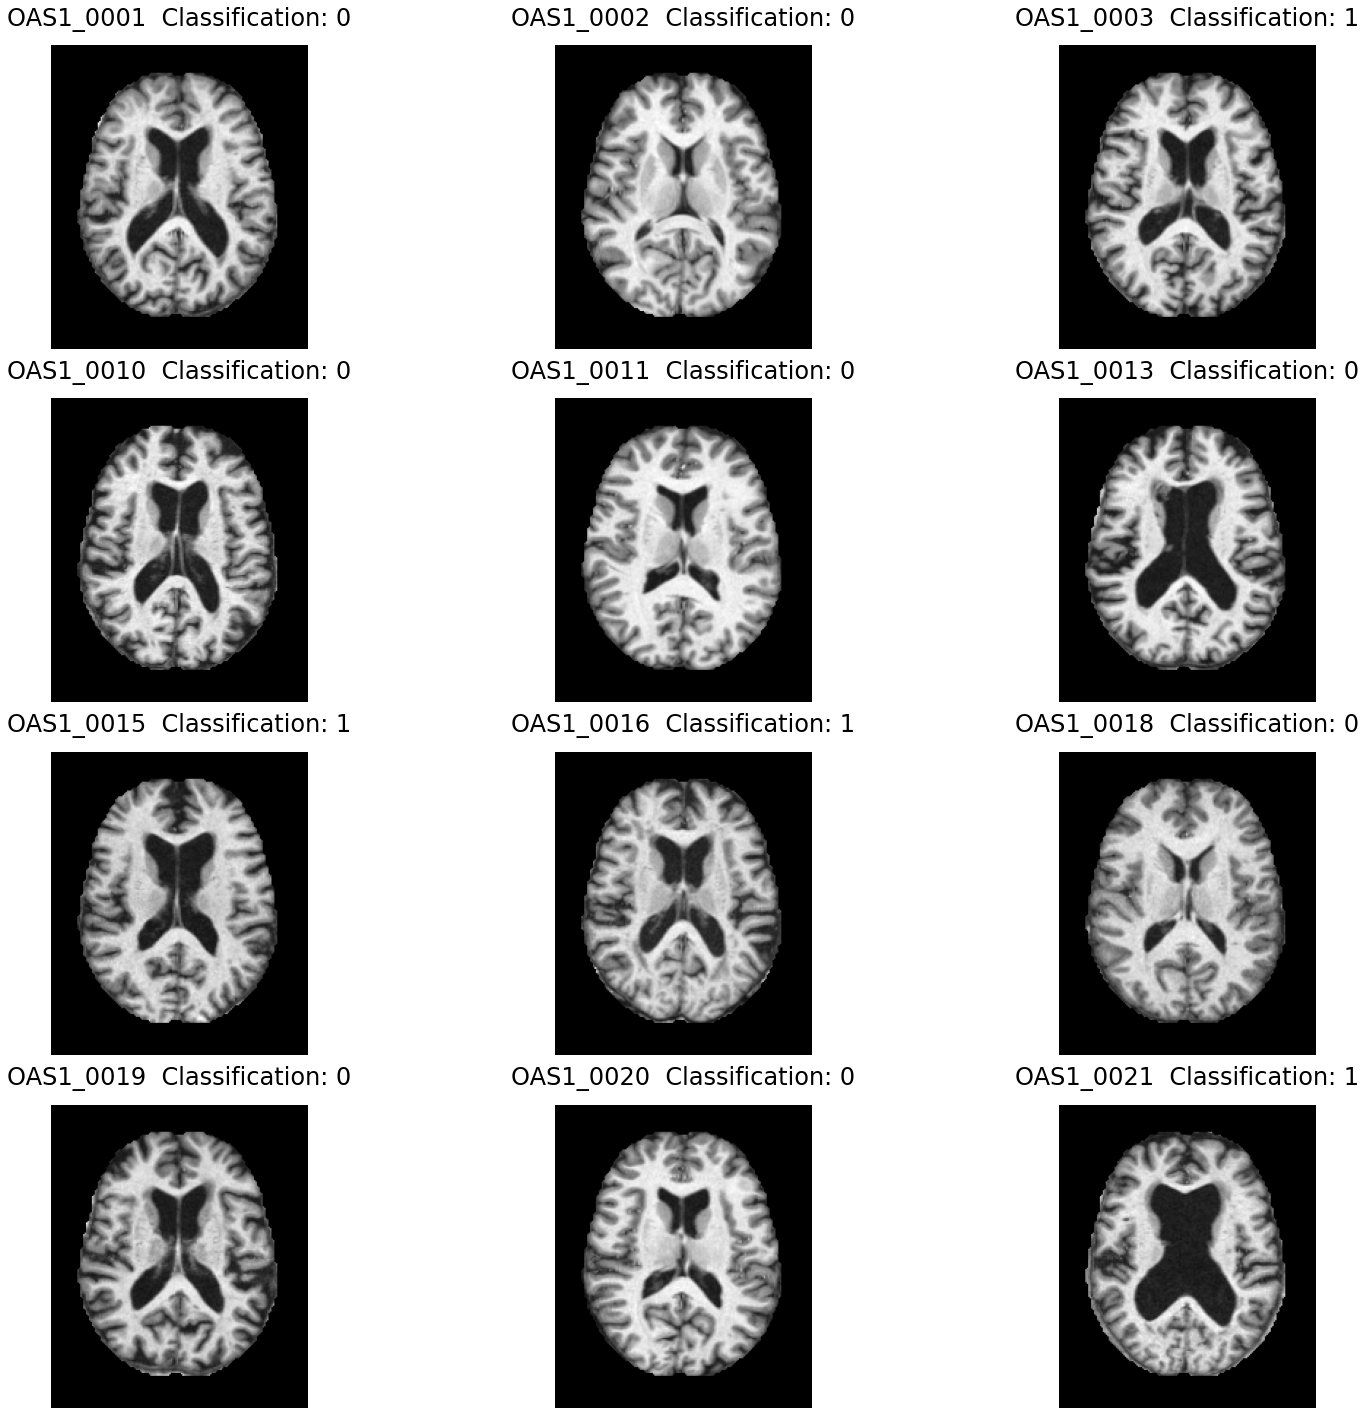

In [158]:
def plot_test_images(subject, diagnosis, array):
    plt.figure(figsize = (20, 20))
    #print("Test Images".center(os.get_terminal_size().columns))
    for i in range(12):
        plt.subplot(4, 3, i+1)
        plt.title(str(subject[i]) +'  Classification: ' + str(diagnosis[i]), fontsize=24, pad = 20)
        plt.tight_layout()
        plt.axis('off')
        plt.imshow(array[i], cmap = 'gray')
        plt.subplots_adjust(wspace = 0.25)
    plt.show()  
    
plot_test_images(oas1_masked_gifs_df['Subject_ID'], oas1_masked_gifs_df['CDR'], oas1_masked_gifs_df.img)

## Train Test Split

In [145]:
X_oas1_masked_gifs = convert2tensor(oas1_masked_gifs_df['img'].values)
y_oas1_masked_gifs = oas1_masked_gifs_df['CDR'].values

In [148]:
X_oas1_masked_gifs.shape

(235, 208, 176, 1)

In [149]:
y_oas1_masked_gifs.shape

(235,)

In [151]:
X_train_oas1_masked, X_test_oas1_masked, y_train_oas1_masked, y_test_oas1_masked =\
train_test_split(X_oas1_masked_gifs, y_oas1_masked_gifs, test_size=0.3, random_state=42)

## Model

In [150]:
basic_cnn_oas1_masked = create_model(X_oas1_masked_gifs[0].shape)

In [152]:
history_oas1_masked = basic_cnn_oas1_masked.fit(X_train_oas1_masked, y_train_oas1_masked, 
                                epochs=500,
                                verbose=0,
                                batch_size=32,
                                callbacks=[es])

In [153]:
basic_cnn_oas1_masked.evaluate(X_test_oas1_masked, y_test_oas1_masked)

3/3 [==============================] - 1s 3ms/step - loss: 0.6790 - accuracy: 0.5915 - recall: 0.0000e+00 - precision: 0.0000e+00


[0.6789794564247131, 0.591549277305603, 0.0, 0.0]

In [181]:
basic_cnn_oas1_masked = create_model(X_oas1_masked_gifs[0].shape)

es = EarlyStopping(monitor='loss', 
                   min_delta=0, 
                   patience=10, 
                   verbose=0, 
                   mode='auto')

basic_cnn_oas1_masked.compile(loss='binary_crossentropy', 
                              optimizer='adam', 
                              metrics=['accuracy'])

basic_cnn_oas1_masked.fit(X_train_oas1_masked, 
                          y_train_oas1_masked, 
                          epochs=600, 
                          batch_size=75, 
                          callbacks=[es])

Epoch 1/600
3/3 [==============================] - 0s 7ms/step - loss: 0.6912 - accuracy: 0.5671
Epoch 2/600
3/3 [==============================] - 0s 8ms/step - loss: 0.6845 - accuracy: 0.5671
Epoch 3/600
3/3 [==============================] - 0s 8ms/step - loss: 0.6841 - accuracy: 0.5671
Epoch 4/600
3/3 [==============================] - 0s 7ms/step - loss: 0.6835 - accuracy: 0.5671
Epoch 5/600
3/3 [==============================] - 0s 8ms/step - loss: 0.6825 - accuracy: 0.5671
Epoch 6/600
3/3 [==============================] - 0s 8ms/step - loss: 0.6853 - accuracy: 0.5671
Epoch 7/600
3/3 [==============================] - 0s 7ms/step - loss: 0.6880 - accuracy: 0.5671
Epoch 8/600
3/3 [==============================] - 0s 8ms/step - loss: 0.6869 - accuracy: 0.5671
Epoch 9/600
3/3 [==============================] - 0s 8ms/step - loss: 0.6833 - accuracy: 0.5671
Epoch 10/600
3/3 [==============================] - 0s 7ms/step - loss: 0.6810 - accuracy: 0.5671
Epoch 11/600
3/3 [===========

In [182]:
basic_cnn_oas1_masked.evaluate(X_test_oas1_masked, y_test_oas1_masked)

3/3 [==============================] - 0s 2ms/step - loss: 1.3732 - accuracy: 0.6761


[1.3732150793075562, 0.6760563254356384]

In [195]:
y_pred_oas1_masked = np.round(basic_cnn_oas1_masked.predict(X_test_oas1_masked), 0)

In [196]:
recall_score(y_test_oas1_masked, y_pred_oas1_masked)

0.5172413793103449

In [197]:
precision_score(y_test_oas1_masked, y_pred_oas1_masked)

0.625

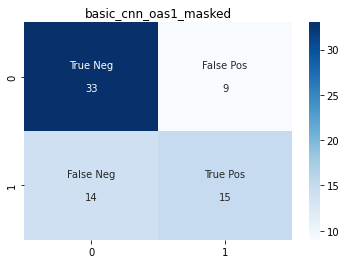

In [274]:
y_pred_oas1_masked = np.round(basic_cnn_oas1_masked.predict(X_test_oas1_masked), 0)

conf_matrix_oas1_masked = confusion_matrix(y_true=y_test_oas1_masked, y_pred=y_pred_oas1_masked)

plot_cf_matrix(conf_matrix_oas1_masked, 'basic_cnn_oas1_masked')

# ResNet50

In [275]:
base_model_resnet50 = ResNet50(include_top=False,
                          weights=None,
                          input_shape=(208, 176, 1),
                          pooling=None,
                          classes=2)

model_resnet50 = Sequential()
model_resnet50.add(base_model_resnet50)
model_resnet50.add(Flatten())
model_resnet50.add(Dropout(0.5))
model_resnet50.add(Dense(1, activation='sigmoid'))

model_resnet50.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', 'Recall', 'Precision']
)

In [276]:
model_resnet50.fit(X_train_oas1_masked, 
                   y_train_oas1_masked,
                   epochs=600, 
                   batch_size=32, 
                   callbacks=[es])

6/6 [==============================] - 46s 6s/step - loss: 8.5844 - accuracy: 0.6037 - recall: 0.4648 - precision: 0.5500


In [278]:
model_resnet50.evaluate(X_test_oas1_masked, y_test_oas1_masked)

3/3 [==============================] - 5s 907ms/step - loss: 1038.8606 - accuracy: 0.4085 - recall: 1.0000 - precision: 0.4085


[1038.860595703125, 0.4084506928920746, 1.0, 0.4084506928920746]

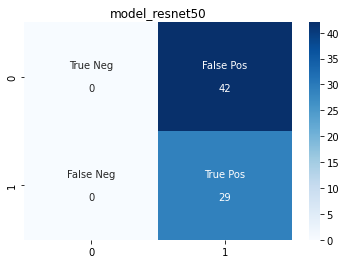

In [279]:
y_pred_oas1_masked_resnet50 = np.round(model_resnet50.predict(X_test_oas1_masked,), 0)

conf_matrix_oas1_masked_resnet50 = confusion_matrix(y_true=y_test_oas1_masked, y_pred=y_pred_oas1_masked_resnet50)

plot_cf_matrix(conf_matrix_oas1_masked_resnet50, 'model_resnet50')

# PCA

In [ ]:
m_PCA = PCA(n_components=10)
m_PCA.fit(oas1_masked_gifs_df['img'].values) # fit data with PCA algorithm
X_pca_oas1_masked_gifs = m_PCA.transform(X_oas1_masked_gifs)

In [282]:
X_pca_oas1_masked_gifs

(235, 208, 176, 1)